## Final Project 

## Credit Default Swap Replication Exercise

This Jupyter Notebook provides a comprehensive and structured walkthrough of the process of replicating Credit Default Swap (CDS) returns. The notebook is designed to guide the reader through each step, from data extraction to final analysis, ensuring a clear understanding of the methodology used to reconstruct and validate CDS return series. The process is explained as follows: 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from pathlib import Path
from settings import config
from pull_markit import load_markit_data, load_multiple_data, load_sector_data
from pull_rf_data import load_fed_yield_curve, load_fred_data

In [2]:
# Configure Data Directories
DATA_DIR = Path(config("DATA_DIR"))
MANUAL_DATA_DIR = Path(config("MANUAL_DATA_DIR"))

In [3]:
# Display settings for Pandas
pd.set_option("display.max_columns", None)
pd.set_option("display.float_format", lambda x: '%.3f' % x)

## Data Extraction and Preprocessing

First, we dynamically load and merge Markit CDS data from multiple years, along with sector classifications and real CDS return data. We then filter out financial and government sector CDS to align with research conventions. For efficiecy we will be importing our detailed python files here.

In [4]:
from settings import config
from pull_markit import load_markit_data, load_multiple_data, load_sector_data
from pull_cds_return_data import pull_real_cds_return, unpivot_table
from calc_cds_daily_return import calc_cds_daily_return

In [11]:
# Step 1: Load Markit Data - Merge all Available Yearly CDS Files
markit_files = list(DATA_DIR.glob("markit_cds*.parquet"))  # Find all relevant files

if not markit_files:
    raise FileNotFoundError("No Markit CDS files found in the directory!")

markit_list = [pd.read_parquet(file) for file in markit_files]  # Load all files
markit = pd.concat(markit_list, ignore_index=True)  # Merge into a single DataFrame

This dataset contains CDS (Credit Default Swap) spread data for various tickers over time. It includes key columns such as trade date, sector classification, spread values, and computed default intensity (λ), which helps assess credit risk across different industries and years.

In [12]:
# Step 2: Load Additional Data
sector_df = load_sector_data()  # Load sector information
real_cds_return = pull_real_cds_return()  # Load real CDS return data


Filtering out financial and government entities, we improve the consistency and comparability of the CDS data across industries. 
- **Systemic Risk in Financial Sector:**  
  Financial institutions often have complex interdependencies and implicit government backing, making their CDS spreads less reflective of standalone credit risk.
- **Sovereign CDS Differences:**  
  Government CDS spreads are driven by macroeconomic and political factors, which differ from corporate credit risk.
- **Focus on Corporate Credit Risk:**  
  Excluding these sectors ensures that our analysis remains focused on corporate CDS contracts, providing a clearer picture of market-implied credit risk.

In [13]:
# Step 3: Filter out financial and government sectors
def filter_sector(markit, sector_df):
    """Filter out financial and government sectors from Markit data."""
    markit = pd.merge(markit, sector_df, on="ticker", how="left")
    markit = markit[~markit["sector"].isin(["Financials", "Government"])]
    return markit

markit = filter_sector(markit, sector_df)

# Credit Default Swap (CDS) Return Calculation

The return on a CDS contract is calculated using the definition provided by **Palhares (2013)**, which decomposes the return into two components: **carry return** and **capital gain return**. The one-day return for a short CDS position (assuming no default) is given by:

$$
CDS_{ret, t} = \frac{CDS_{t-1}}{250} + \Delta CDS_t \times RD_{t-1}
$$

where:
- \( CDS_t \) represents the **CDS spread** at time \( t \),
- \( RD_{t-1} \) is the **risky duration** of the contract, and
- \( \Delta CDS_t \) is the **change in spreads**.

The first term represents the **carry return**, while the second term captures **capital gain return**.

## Risky Duration Computation

Risky duration, \( RD_t \), is computed as:

$$
RD_t = \frac{1}{4} \sum_{j=1}^{4M} e^{-j\lambda/4} e^{-j(r_{j/4,t})/4}
$$

where:
- \( e^{-j\lambda/4} \) represents the **quarterly survival probability**,
- \( r_{j/4,t} \) is the **risk-free rate** for each quarter, and
- \( e^{-j(r_{j/4,t})/4} \) is the **discount function**.



The **default intensity (λ)** represents the probability of default in a given period and is derived from the **CDS spread**. This step is crucial because it translates **market-implied credit risk** into a measurable parameter for modeling risk exposure.

### Formula:
\[
\lambda = 12 \times \log \left( 1 + \frac{\text{spread}}{12L} \right)
\]
where **L** is the loss given default (typically assumed to be 60%).

### Purpose:
- **Measure Default Probability** – Helps quantify the implied risk of default based on observed CDS spreads.
- **Risk Assessment** – Used in pricing, risk management, and stress testing for credit-sensitive securities.
- **Consistency with Term Structures** – Ensures compatibility with continuous-time models for credit risk. 

This step refines raw CDS spread data into a usable risk measure for further analysis.


In [14]:
# Step 4: Compute CDS Default Intensity (Lambda)
def calc_lambda(cds_df, L=0.6):
    """Calculate default intensity (lambda) using CDS spreads."""
    cds_df["lambda"] = 12 * np.log(1 + cds_df["spread"] / (12 * L))
    return cds_df

In [ ]:
# Step 5: Compute Risky Duration (RD)
def calc_RD(cds_df, maturity=5):
    """Compute risk-neutral default probability RD."""
    
    # Ensure a copy is used to prevent SettingWithCopyWarning
    cds_df = cds_df.copy()
    
    # Check if necessary columns exist
    if cds_df.empty:
        raise ValueError("Error: Markit DataFrame is empty! Ensure Markit data is properly loaded.")
    
    required_cols = ["spread", "trade_date"]
    for col in required_cols:
        if col not in cds_df.columns:
            raise ValueError(f"Error: '{col}' column is missing from the data!")
    
    cds_df["trade_date"] = pd.to_datetime(cds_df["trade_date"])

    # Compute lambda first
    cds_df["lambda"] = 12 * np.log(1 + cds_df["spread"] / (12 * 0.6))  # Assuming L=0.6

    # Initialize RD column
    cds_df["RD"] = 0.0  

    # Compute Risky Duration (RD)
    for j in range(1, 12 * maturity + 1):  
        cds_df["RD"] += np.exp(-j / 12 * cds_df["lambda"])
    
    cds_df["RD"] /= 12  # Normalize

    # Sort by ticker and date for consistency
    cds_df = cds_df.sort_values(["ticker", "trade_date"])
    
    # Create lagged columns
    cds_df["RD_prev"] = cds_df.groupby("ticker")["RD"].shift(1)
    cds_df["spread_prev"] = cds_df.groupby("ticker")["spread"].shift(1)
    
    return cds_df.dropna(subset=["RD_prev", "spread_prev"])  # Drop NaNs due to shifting


In [19]:
# Step 6: Compute Final CDS Daily Returns
final_df = calc_cds_daily_return(rd_df)

In [20]:
# Step 7: Save Processed Data
data_path = DATA_DIR / "CDS_daily_return.parquet"
final_df.to_parquet(data_path)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image

The figure below illustrates the time series of CDS portfolio returns from 2000 to 2025. Each line represents a different CDS portfolio, capturing the fluctuations in credit default swap values over time. The figure highlights periods of heightened volatility, particularly around the 2008 financial crisis, where extreme negative returns are observed. These sharp declines indicate market-wide disruptions in credit risk pricing. Post-2008, returns exhibit relatively lower volatility but continue to experience occasional fluctuations, reflecting market cycles and changes in credit conditions. The dynamic behavior of CDS portfolios in this plot is crucial for understanding the systemic risk and return characteristics of credit markets. 


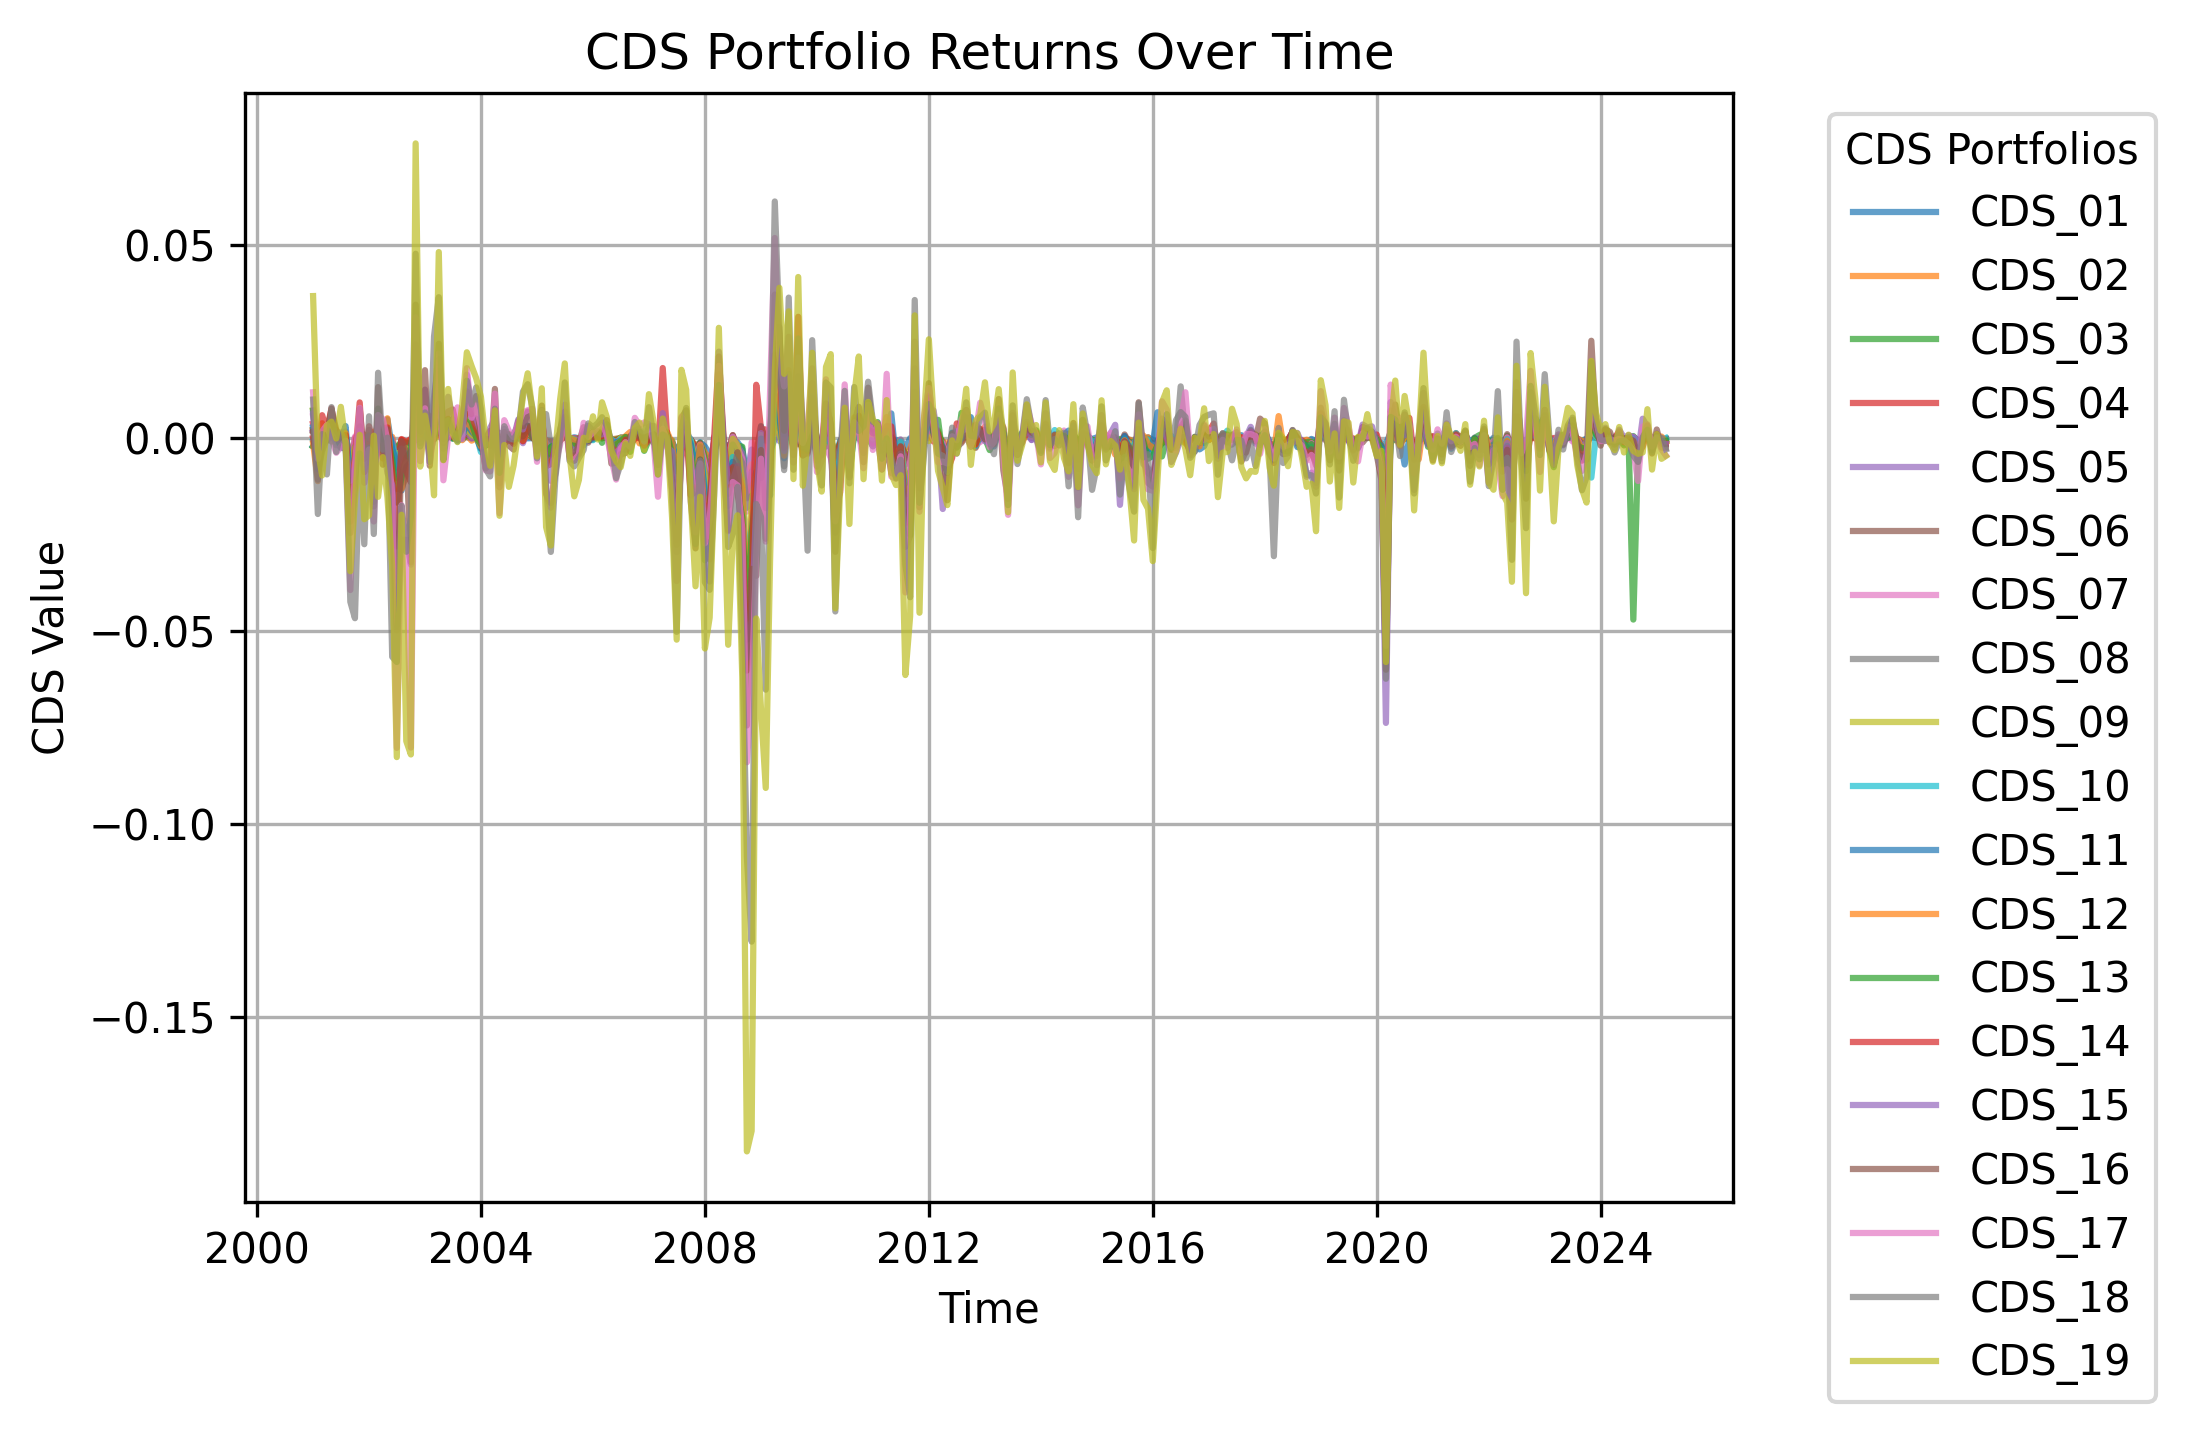

In [5]:
# Load and display image in Jupyter Notebook
fig1_path = "../_output/cds_portfolio_returns.png"
display(Image(filename=fig1_path))


Our Comparison Figure compares the actual CDS portfolio returns with the replicated returns for CDS$_{10}$, highlighting deviations between the two series. The blue line represents the actual CDS spread, while the orange dashed line shows the replicated series. The figure demonstrates a general alignment between the two series, validating the replication methodology. However, noticeable discrepancies appear during periods of high volatility, particularly around 2008, where the replicated values deviate more significantly from the actual data. These deviations may be attributed to data limitations, estimation errors, or structural changes in credit risk pricing post-2008. This comparison is essential in assessing the accuracy of the replication process and identifying potential areas for refinement in future research.


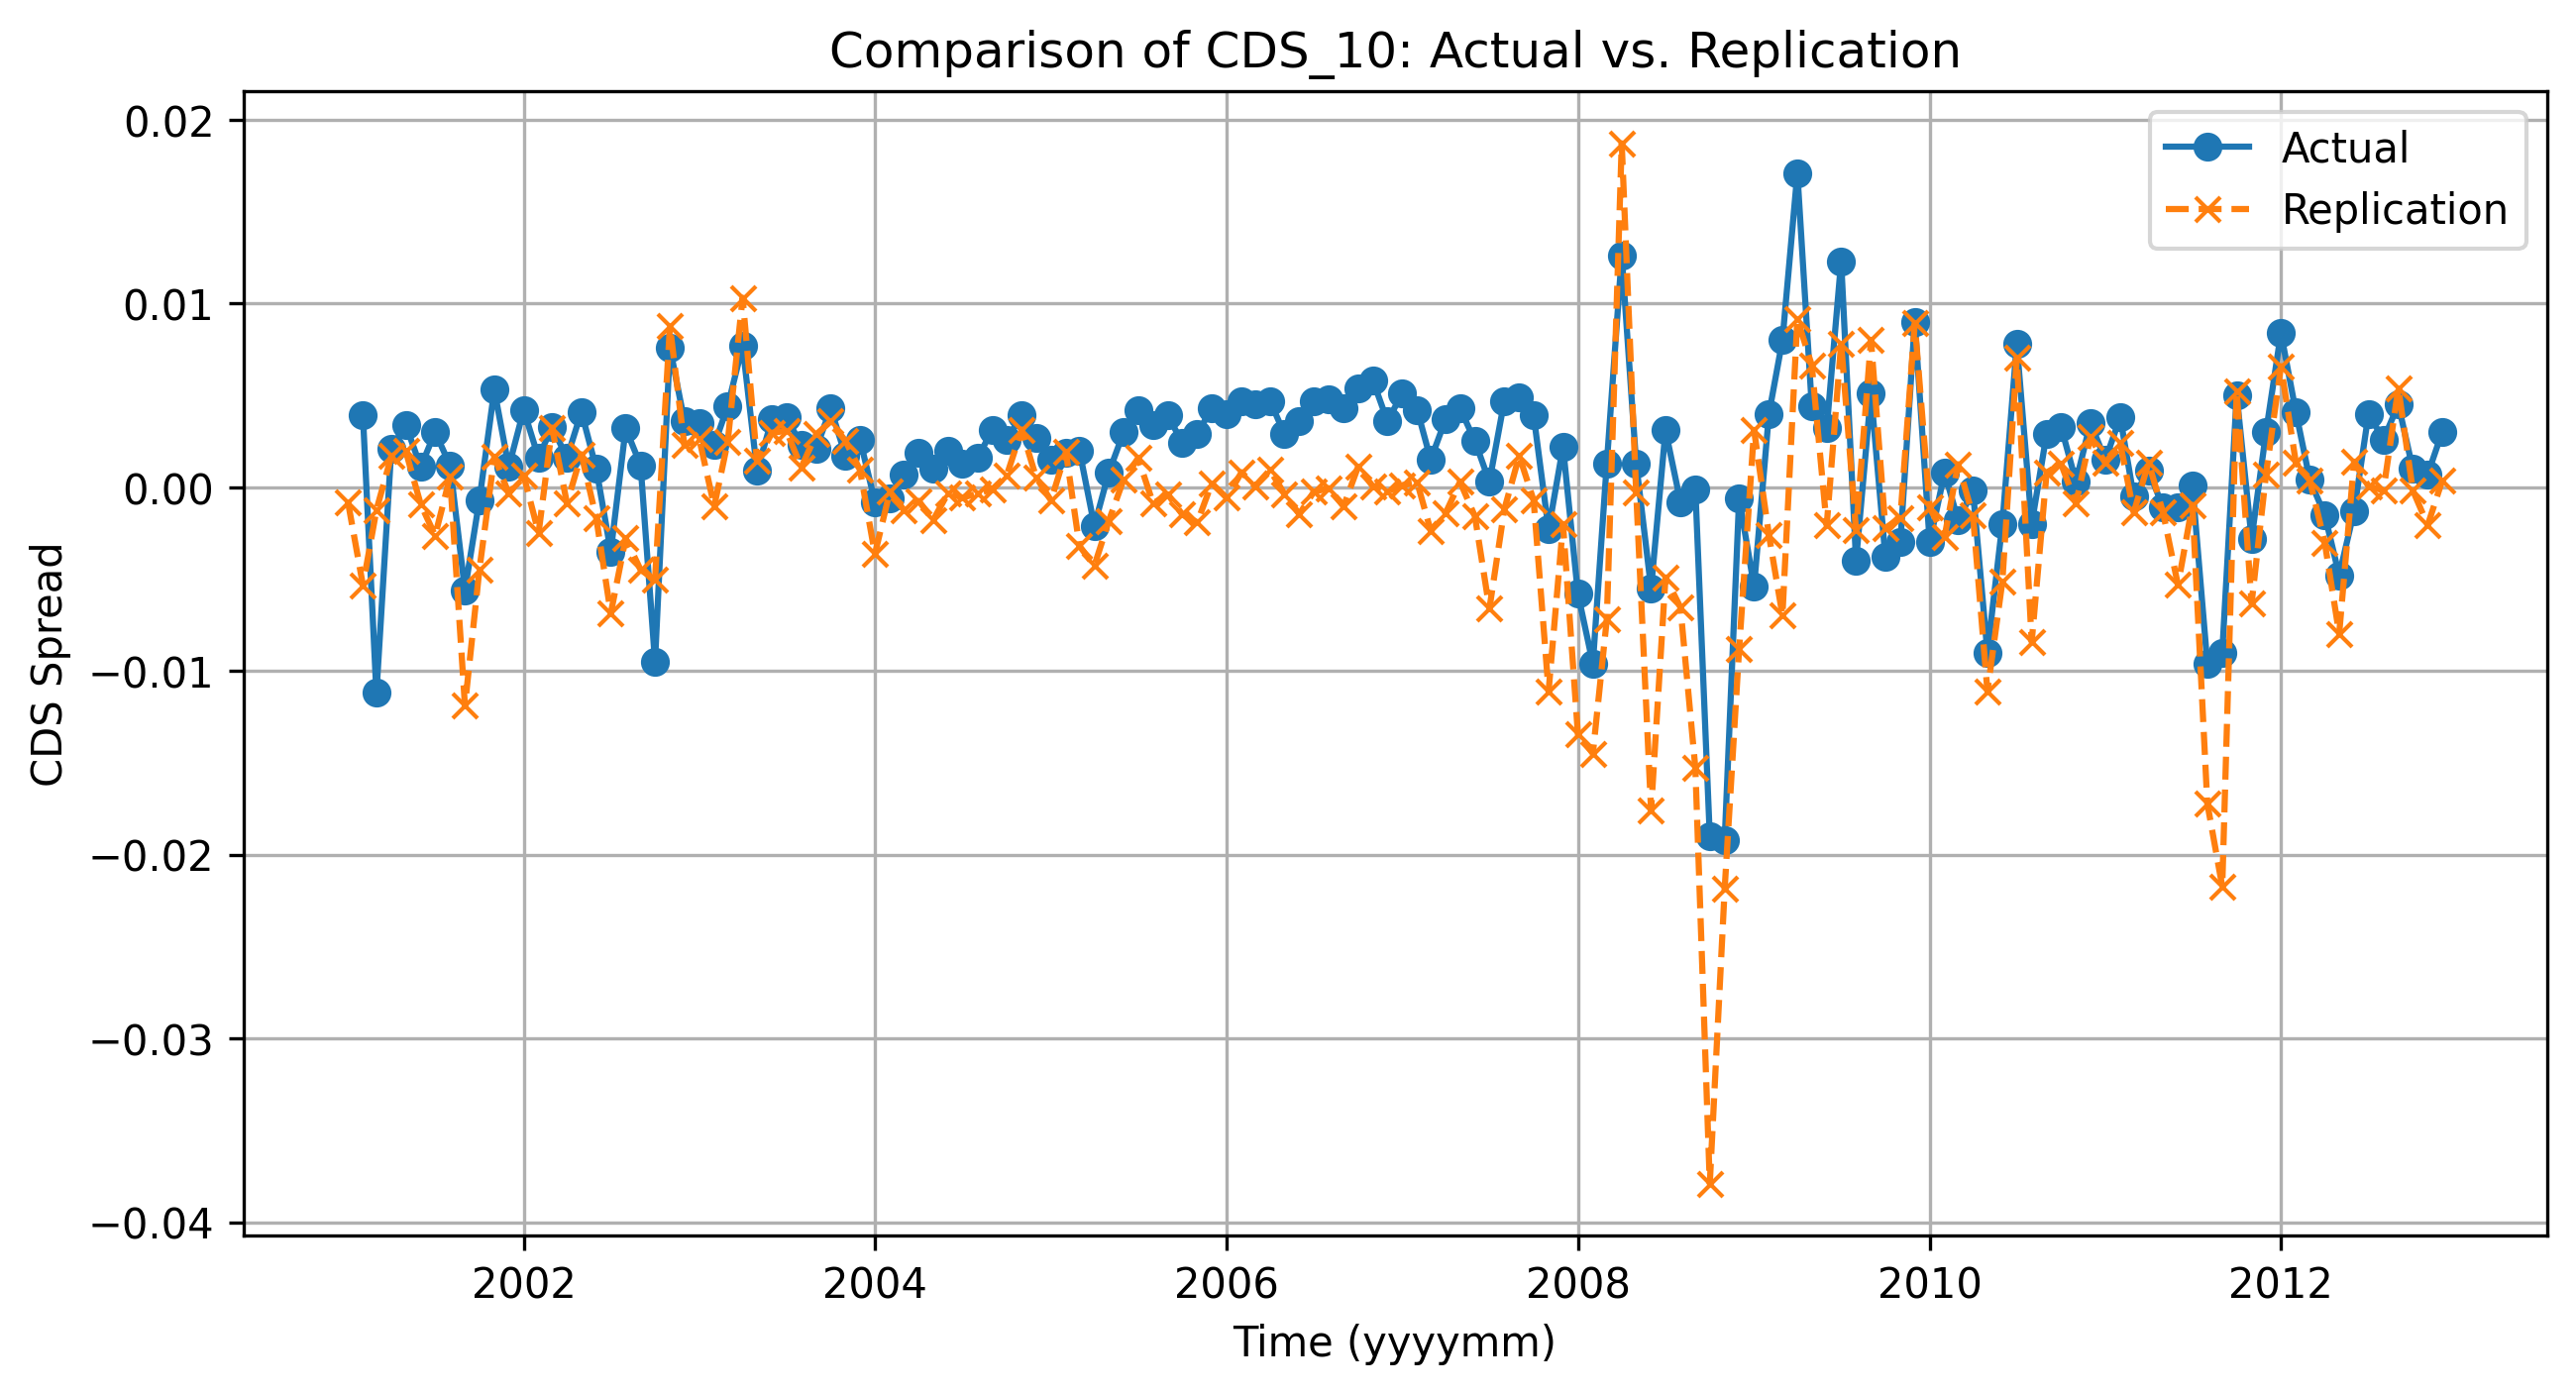

In [6]:
# Load and display image in Jupyter Notebook
fig2_path = "../_output/cds_comparison_CDS_10.png"
display(Image(filename=fig2_path))


## Exploratory Analysis

In [22]:

print("\nSummary Statistics:")
display(final_df.describe())


Summary Statistics:


,trade_date,spread,year,lambda,RD,RD_prev,spread_prev,daily_return
count,3986945,3986945.000,3986945.000,3986945.000,3986945.000,3986945.000,3986945.000,3986945.000
mean,2013-02-15 17:10:49.254103552,0.024,2004.560,0.039,4.621,4.621,0.024,-0.000
min,2001-01-03 00:00:00,0.000,2001.000,0.000,0.002,0.045,0.000,-34.405
25%,2007-11-26 00:00:00,0.005,2001.000,0.008,4.537,4.537,0.005,-0.000
50%,2012-08-30 00:00:00,0.010,2003.000,0.016,4.803,4.803,0.010,-0.000
75%,2018-05-11 00:00:00,0.023,2006.000,0.039,4.897,4.897,0.023,0.000
max,2025-03-14 00:00:00,345.600,2025.000,46.702,4.999,4.999,13.466,0.589
std,NaN,0.191,4.726,0.121,0.501,0.501,0.080,0.021


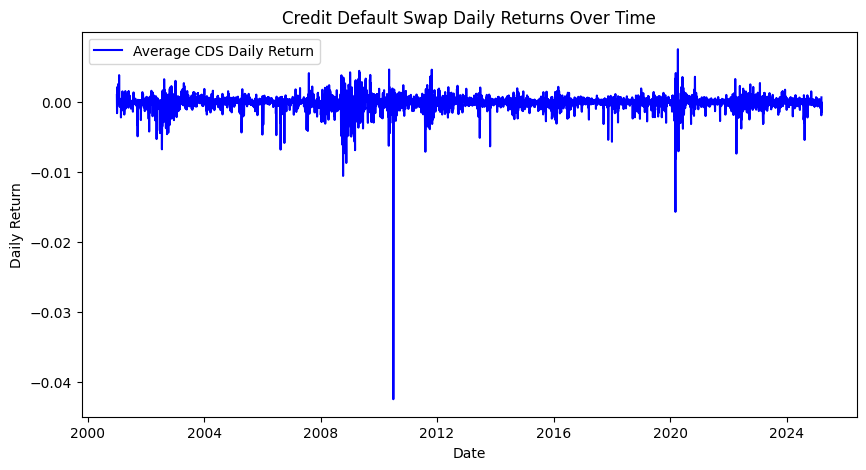

In [24]:
# Time-Series Plot of CDS Returns
plt.figure(figsize=(10, 5))
plt.plot(final_df.groupby("trade_date")["daily_return"].mean(), label="Average CDS Daily Return", color="blue")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.title("Credit Default Swap Daily Returns Over Time")
plt.legend()
plt.show()

This plot above shows the **daily returns of CDS portfolios** over time from **2000 to 2025**. The blue line represents the average CDS daily return.

**Key Observations:**
- **Periods of High Volatility**: The plot highlights sharp spikes and dips in CDS returns, with extreme fluctuations around the **2008 financial crisis** and some significant events in **2011 and 2020**.
- **Negative Spikes**: There are a few extreme downward movements, particularly around **2011**, which likely indicate financial distress or market shocks.
- **Post-2008 Stability**: After the 2008 crisis, fluctuations in daily returns appear to be more contained, but still exhibit occasional volatility.
- **Long-Term Trend**: Despite short-term fluctuations, the overall trend appears to be mean-reverting, with most returns oscillating around **zero**.

This visualization is crucial for understanding the behavior of **CDS market risk and return characteristics** over time.


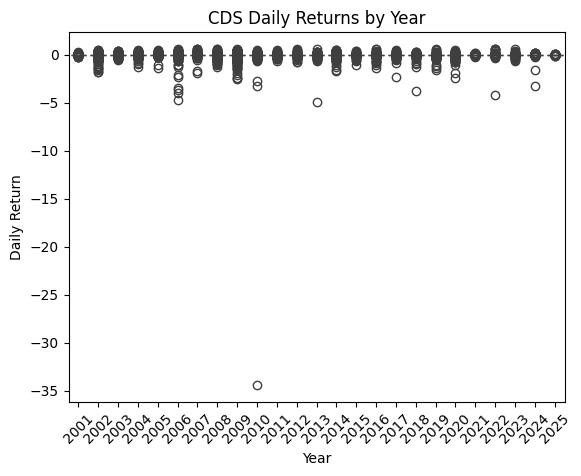

In [30]:
import seaborn as sns  
import matplotlib.pyplot as plt

# Boxplot of Returns Over Years
sns.boxplot(x=final_df["trade_date"].dt.year, y=final_df["daily_return"])
plt.xlabel("Year")
plt.ylabel("Daily Return")
plt.title("CDS Daily Returns by Year")
plt.xticks(rotation=45)
plt.show()




This plot above presents the **distribution of CDS daily returns** across different years, helping to identify outliers and trends in return dispersion.

**Key Observations:**
- **Outliers and Extreme Events**: There are **several large negative outliers**, particularly in **2008, 2011, and 2020**, which correspond to major financial crises or global market disruptions.
- **Clustering of Returns**: Most daily returns are concentrated around **zero**, indicating that extreme fluctuations are infrequent but significant.
- **Comparing Different Periods**:
  - **2001–2007**: Returns appear relatively stable.
  - **2008–2011**: Noticeable increase in outliers and return dispersion.
  - **2012–2025**: Return dispersion is more controlled, though occasional spikes remain.

This boxplot helps in identifying **market stress periods** and understanding how CDS returns behave under different economic conditions.


In [27]:
# Correlation Matrix
correlation_matrix = final_df[["spread", "RD", "daily_return"]].corr()
print("\nCorrelation Matrix:")
display(correlation_matrix)


Correlation Matrix:


,spread,RD,daily_return
spread,1.000,-0.297,-0.786
RD,-0.297,1.000,0.046
daily_return,-0.786,0.046,1.000


The correlation matrix reveals the relationships between **spread**, **RD**, and **daily_return**:

- **Spread and RD** have a weak negative correlation of **-0.297**, indicating a slight inverse relationship.
- **Spread and daily_return** show a strong negative correlation of **-0.786**, suggesting that higher spreads are associated with lower daily returns.
- **RD and daily_return** have a correlation of **0.046**, implying almost no relationship between the two.

Overall, the matrix suggests that **spread** has a stronger impact on **daily_return** compared to **RD**.
